<div style="
    border: 2px solid #4CAF50; 
    padding: 15px; 
    background-color: #f4f4f4; 
    border-radius: 10px; 
    align-items: center;">

<h1 style="margin: 0; color: #4CAF50;">Neural Networks: Deployment, Import und Export von Modellen</h1>
<h2 style="margin: 5px 0; color: #555;">DSAI</h2>
<h3 style="margin: 5px 0; color: #555;">Jakob Eggl</h3>

<div style="flex-shrink: 0;">
    <img src="https://www.htl-grieskirchen.at/wp/wp-content/uploads/2022/11/logo_bildschirm-1024x503.png" alt="Logo" style="width: 250px; height: auto;"/>
</div>
<p1> © 2025/26 Jakob Eggl. Nutzung oder Verbreitung nur mit ausdrücklicher Genehmigung des Autors.</p1>
</div>
<div style="flex: 1;">
</div>   

Wir wollen uns in diesem Notebook mit 3 wichtigen Konzepten beschäftigen:

1) Model Import/Export
2) Verwenden und/oder Finetuning von vortrainierten (pretrained) Modellen
3) Model Deployment mit Flask

Die Motivation für diese Themen ist einfach. In vielen Fällen wäre es praktisch, das fertig trainierte Modell anderen zur Verfügung zu stellen. Diese können dieses dann entweder nur verwenden (online darauf zugreifen), oder, falls das ganze Modell geteilt wird, mit diesem auch weitere Dinge, wie zum Beispiel Finetuning etc., erledigen.

# Model Import/Export

In diesem Teil wollen wir unser Modell als Datei exportieren, bzw. im Anschluss wieder importieren.

### PyTorch Export

Wir starten mit einem normalen Modell, welches wir später exportieren wollen.

In [81]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
from torch import nn
from torch.utils.data import DataLoader, random_split, TensorDataset
from sklearn.preprocessing import OrdinalEncoder, StandardScaler
import torch.optim as optim
import onnx
import onnxruntime as ort

In [82]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('mps') if torch.backends.mps.is_available() else torch.device('cpu')
print(device)

cpu


In [83]:
class SimpleRegressor(nn.Module):
    def __init__(self):
        super(SimpleRegressor, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(12, 24),
            nn.ReLU(),
            nn.Linear(24, 12),
            nn.ReLU(),
            nn.Linear(12, 6),
            nn.ReLU(),
            nn.Linear(6, 1)
            )
    def forward(self, x):
        return self.net(x)

In [84]:
model = SimpleRegressor().to(device)

In [85]:
# Simulation of a train method

def train_model(model, epochs):
    print("Started Dummy Training the model...")
    model.train()
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    criterion = nn.MSELoss()
    for epoch in range(epochs):
        # Dummy data
        inputs = torch.randn(32, 12).to(device)
        targets = torch.randn(32, 1).to(device)
        
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        
        if (epoch+1) % 1 == 0:
            print(f'Epoch [{epoch+1}/{epochs}], Loss: {loss.item():.4f}')

    print("Finished training the model.")
    return model

In [86]:
model = train_model(model, epochs=100)

Started Dummy Training the model...
Epoch [1/100], Loss: 1.2140
Epoch [2/100], Loss: 0.8031
Epoch [3/100], Loss: 1.2870
Epoch [4/100], Loss: 1.4929
Epoch [5/100], Loss: 1.7952
Epoch [6/100], Loss: 0.7782
Epoch [7/100], Loss: 0.6903
Epoch [8/100], Loss: 0.6253
Epoch [9/100], Loss: 0.8758
Epoch [10/100], Loss: 0.7644
Epoch [11/100], Loss: 0.7986
Epoch [12/100], Loss: 0.8123
Epoch [13/100], Loss: 0.9833
Epoch [14/100], Loss: 0.9311
Epoch [15/100], Loss: 1.1370
Epoch [16/100], Loss: 1.0218
Epoch [17/100], Loss: 0.7389
Epoch [18/100], Loss: 0.6206
Epoch [19/100], Loss: 1.3688
Epoch [20/100], Loss: 0.8149
Epoch [21/100], Loss: 1.1958
Epoch [22/100], Loss: 0.9766
Epoch [23/100], Loss: 0.9688
Epoch [24/100], Loss: 0.9180
Epoch [25/100], Loss: 0.9970
Epoch [26/100], Loss: 0.8746
Epoch [27/100], Loss: 1.3388
Epoch [28/100], Loss: 0.7889
Epoch [29/100], Loss: 1.2510
Epoch [30/100], Loss: 1.2772
Epoch [31/100], Loss: 1.0001
Epoch [32/100], Loss: 0.9372
Epoch [33/100], Loss: 1.3004
Epoch [34/100], 

In [87]:
aux_data = torch.tensor([1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0,10.0,11.0,12.0]).to(device).unsqueeze(0)

In [88]:
output = model(aux_data)

In [89]:
output

tensor([[0.2852]], grad_fn=<AddmmBackward0>)

Nun wollen wir dieses Model exportieren. Dafür haben wir mehrere Möglichkeiten.

**Exportieren via State Dictionary**

Ist die am häufigsten verwendete und empfohlene Methode. Dabei wird das `state_dict` gespeichert, welches ein Python-Dictionary ist und alle trainierten Parameter beinhaltet.

In [90]:
export_path = os.path.join("..", "models", "nn_6_simple_regressor_state_dict.pth")

torch.save(model.state_dict(), export_path)
print(f"Model state_dict saved to {export_path}")

Model state_dict saved to ../models/nn_6_simple_regressor_state_dict.pth


In [91]:
model = SimpleRegressor().to(device)
model.eval()
output_before_import = model(aux_data)
print("Output before loading state_dict:", output_before_import)

Output before loading state_dict: tensor([[-0.1205]], grad_fn=<AddmmBackward0>)


In [92]:
# load model
model.load_state_dict(torch.load(export_path, map_location=device))
model.eval()
output_after_import = model(aux_data)
print("Output after loading state_dict:", output_after_import)

Output after loading state_dict: tensor([[0.2852]], grad_fn=<AddmmBackward0>)


**Wichtig:** Es ist in diesem Fall natürlich auch die Struktur vom Modell zu kennen, also es werden nur die Weights importiert/exportiert. Der dazugehörige Computational Graph (sprich die `forward()` Methode) ist hier nicht dabei.

Sollte es nicht möglich sein, die Modellklasse bereit zu halten, bzw. falls wir das Modell wirklich "komplett" exportieren wollen, so stehen uns folgende Möglichkeiten zur Verfügung.

### ONNX Export

Falls wir uns für den Export via Open Neural Network Exchange entscheiden, so läuft dies folgendermaßen ab:

Zuerst müssen wir das Modul `onnx` installieren. Dafür verwenden wir `pip install onnx onnxscript onnxruntime`

In [93]:
onnx_export_path = os.path.join("..", "models", "nn_6_simple_regressor.onnx")

torch.onnx.export(model, aux_data, onnx_export_path, input_names=['input'], output_names=['output'])

/tmp/ipykernel_148960/3099032314.py:3: DeprecationWarning: You are using the legacy TorchScript-based ONNX export. Starting in PyTorch 2.9, the new torch.export-based ONNX exporter will be the default. To switch now, set dynamo=True in torch.onnx.export. This new exporter supports features like exporting LLMs with DynamicCache. We encourage you to try it and share feedback to help improve the experience. Learn more about the new export logic: https://pytorch.org/docs/stable/onnx_dynamo.html. For exporting control flow: https://pytorch.org/tutorials/beginner/onnx/export_control_flow_model_to_onnx_tutorial.html.
  torch.onnx.export(model, aux_data, onnx_export_path, input_names=['input'], output_names=['output'])


**Hinweis:** Es gibt hier noch weitere Argumente in der onnx.export Methode, jedoch reichen für unsere Anwendung hier die genannten Parameter.

In [94]:
del model

Wir können nun das Modell wieder importieren. Unter anderem können wir uns auch [hier](https://github.com/lutzroeder/netron) (es gibt auf der Seite unten einen Link zur WebApp) das Modell anzeigen.

Wir können es aber auch in Python wieder importieren.

In [95]:
model = onnx.load(onnx_export_path)

**Wichtig:** Das importierte Modell ist nun nicht in PyTorch verfügbar, sondern im ONNX-Format (ONNX-Runtime).

Zuerst überprüfen wir ob der Import funktioniert hat.

In [96]:
res = onnx.checker.check_model(model)

In [97]:
ort_session = ort.InferenceSession(onnx_export_path)

In [ ]:
output = ort_session.run(None, {'input': aux_data.cpu().numpy()})

In [99]:
output

[array([[0.28523487]], dtype=float32)]

Der Output ist wieder gleich!

### TorchScript Export

Die letzte Möglichkeit, die wir uns ansehen werden ist der sogenannte **TorchScript Export**. 

Es erlaubt uns, das Modell zu importieren, ohne die Modell-Struktur kennen zu müssen.

In [100]:
model = SimpleRegressor().to(device)
model = train_model(model, epochs=100)
_ = model.eval()

Started Dummy Training the model...
Epoch [1/100], Loss: 0.8839
Epoch [2/100], Loss: 1.3471
Epoch [3/100], Loss: 1.5558
Epoch [4/100], Loss: 1.1475
Epoch [5/100], Loss: 0.9933
Epoch [6/100], Loss: 1.2930
Epoch [7/100], Loss: 1.3009
Epoch [8/100], Loss: 1.4032
Epoch [9/100], Loss: 1.2986
Epoch [10/100], Loss: 1.5628
Epoch [11/100], Loss: 1.6245
Epoch [12/100], Loss: 0.8749
Epoch [13/100], Loss: 1.0093
Epoch [14/100], Loss: 0.9486
Epoch [15/100], Loss: 1.3173
Epoch [16/100], Loss: 1.2826
Epoch [17/100], Loss: 1.0709
Epoch [18/100], Loss: 0.7309
Epoch [19/100], Loss: 0.7271
Epoch [20/100], Loss: 0.9565
Epoch [21/100], Loss: 0.9427
Epoch [22/100], Loss: 0.8496
Epoch [23/100], Loss: 1.3563
Epoch [24/100], Loss: 1.3468
Epoch [25/100], Loss: 0.5225
Epoch [26/100], Loss: 1.4669
Epoch [27/100], Loss: 1.0838
Epoch [28/100], Loss: 1.2212
Epoch [29/100], Loss: 1.4901
Epoch [30/100], Loss: 0.8856
Epoch [31/100], Loss: 0.9297
Epoch [32/100], Loss: 1.2879
Epoch [33/100], Loss: 0.7851
Epoch [34/100], 

In [101]:
output = model(aux_data)
print("Output from the original model:", output)

Output from the original model: tensor([[1.1867]], grad_fn=<AddmmBackward0>)


In [102]:
model_scripted = torch.jit.script(model)

In [103]:
scripted_model_export_path = os.path.join("..", "models", "nn_6_simple_regressor_scripted.pt")

model_scripted.save(scripted_model_export_path)

In [104]:
del model
del model_scripted

In [105]:
model_scripted_loaded = torch.jit.load(scripted_model_export_path).to(device)
model_scripted_loaded.eval()
output_scripted = model_scripted_loaded(aux_data)
print("Output from the scripted model:", output_scripted)

Output from the scripted model: tensor([[1.1867]], grad_fn=<AddmmBackward0>)


Im Vergleich zu *ONNX* hat *TorchScript* den Nachteil, dass es nur für Torch Systeme funktioniert (Python bzw. C++). 

# Finetuning

Passend zu unserer bisherigen Thematik mit Model Import und Model Export, wollen wir uns nun über FineTuning unterhalten. Dabei geht es darum, dass wir ein bestehendes Modell etwas anpassen. Dabei wollen wir entweder nochmal auf ein spezielles Dataset zusäztlich trainieren, oder wir wollen sogar einen Teil vom neuronalen Netzwerk mit einem neuen Teil ersetzen.

Für die zwei oben genannten Szenarien stelle man sich folgende Beispiele vor:
1) Man will einen "Copilot" zum Python-Programmieren bauen. Dabei nimmt man sich ein bereits funktionierendes Language Model, welches vielleicht generell auf Text, sprich alles im Internet auffindbare, trainiert wurde. Nun verwendet man nochmal ein explizites Dataset, welches nur aus Python-Code besteht und lässt das Modell nochmal einige Iterationen mit diesen Daten trainieren. Dieses Modell sollte dann das Programmieren schneller lernen, als ein ganz neues Modell, weil unser Modell ja schon vorher "lesen" gelernt hat und somit unsere Sprache bereits versteht.
2) Man hat ein sehr generelles Modell, welches gelernt hat Bilder in viele (sagen wir 1000) Klassen zu teilen. Nun möchte man selber einen Bildklassifizierer bauen, der aber nur zwischen Autos, Katzen, Obst und Menschen unterscheiden soll. Dann nimmt man das vorgefertigte Modell und ändert am Schluss nur das letzte Layer und ändert es zu einem (in unserem Fall) `nn.Linear(Z, 4)` Layer. Dabei steht $Z$ für die Output Dimension vom vorigen Layer. Danach trainieren wir nochmal mit unseren Daten. Auch hier nutzen wir dann den Vorteil aus, dass das Modell schon ein Grundverständnis von unserer Welt (wie kann ich Objekte erkennen und vom Hintergrund unterscheiden usw.) hat und auch dieses Modell sollte viel schneller trainieren bzw. eine bessere Performance erreichen.

**Hinweis:** Solche Modelle nennt man dann oft *Foundation Models*.

**Hinweis:** Bei Methode 2 können wir auch mehrere Layers austauschen.

Sehen wir uns nun an, wie wir ein bestehendes Modell finetunen können. 

Dazu möchten wir an dieser Stelle auch zeigen, wie man sich Modelle aus PyTorch herunterladen kann, welche für die Öffentlichkeit zur Verfügung gestellt werden. Als Beispiel nehmen wir das Bildklassifizierungsmodell `ResNet18` [Dokumentation](https://docs.pytorch.org/vision/main/models/generated/torchvision.models.resnet18.html).

In [106]:
from torchvision import models

In [107]:
model = models.resnet18(weights = models.ResNet18_Weights.IMAGENET1K_V1)

Dieses Modell können wir nun nutzen.

Für das FineTuning können wir nun auf die Architektur zugreifen. Wir erklären hier nur kurz den zweiten Ansatz. Der erste ist, sobald wir das Modell haben, selbsterklärend.

In [108]:
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 4)  # New classes are: Auto, Katze, Obst and Mensch

Nun können wir unterscheiden in 2 Teile:
* Wir trainieren alle Weights neu
* Wir trainieren und ändern nur die Weights für den geänderten Layer

Für den ersten Punkt müssen wir nichts machen. Sollten wir aber nur das letzte Layer ändern wollen, so müssen wir bei allen anderen Parametern die "Differenzierbarkeit", wegnehmen. Das machen wir mit folgendem Code.

In [109]:
for name, param in model.named_parameters():
    if "fc" in name: # Only the last fully connected layer is changed
        param.requires_grad = True 
    else:
        param.requires_grad = False # Those weights should not be updated during training. This is called "freezing" the layers.

Das müssen wir dann auch noch dem Optimizer so mitteilen.

In [110]:
optimizer = torch.optim.SGD(
    filter(lambda p: p.requires_grad, model.parameters()), 
    lr=0.001, 
    momentum=0.9
)

Nun können wir dieses Model **finetunen**.

# Model Deployment mit Flask

Zuguterletzt wollen wir uns eine Möglichkeit ansehen, wie wir unser Modell selber hosten können. Wir verwenden dazu Flask.

**Hinweis:** Es gibt noch viele weitere andere Frameworks, wir werden uns aber nur mit Flask beschäftigen.

**Hinweis:** Natürlich kann wie vorher erwähnt das Modell auch in einem entsprechenden Format (zum Beipsie Open Neural Network Exchange (**ONNX**)) exportiert werden und in einer anderen Programmiersprache eingebunden werden. Etwaiger Hardware-Support (GPU) geht dabei eventuell verloren bzw. muss selber implementiert werden.

Wir wechseln nun auf das Python File [nn_6_flask_app](nn_6_flask_app.py). Sobald wir dort den Service gestartet haben, gehen wir wieder hierher zurück.

Wir können nun unser Modell testen.

In [111]:
import requests
import os
import matplotlib.pyplot as plt
from PIL import Image

In [112]:
url = "http://127.0.0.1:5665/predict"

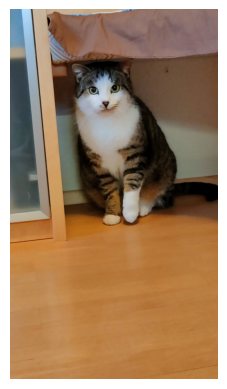

In [113]:
path_of_image = os.path.join("..", "resources", "Columbus.jpeg")

image = Image.open(path_of_image)
plt.imshow(image)
plt.axis("off")
plt.show()

In [114]:
with open(path_of_image, "rb") as f:
    files = {
        "image": (path_of_image, f, "image/jpeg")  # <--- WICHTIG: Filename + MIME-Type
    }
    response = requests.post(url, files=files)
    print(f"Response status code: {response.status_code}")

Response status code: 200


In [115]:
class_labels_path = os.path.join("..", "resources", "imagenet_classes.txt")
with open(class_labels_path) as f:
    class_labels = [line.strip() for line in f.readlines()]

def get_class_name(response, class_labels):
    class_label_response = response.json()
    class_index = class_label_response["predicted_class_index"]
    class_name = class_labels[class_index]
    return class_name, class_index

In [116]:
get_class_name(response, class_labels)

('tabby', 281)

(kann auch nochmal [hier](https://gist.github.com/yrevar/942d3a0ac09ec9e5eb3a) verglichen werden)

Bemerkenswert ist, dass dies nun auch auf der **GPU** läuft, falls verfügbar.